In [1]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import random_split

from torchmetrics.classification import accuracy
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import time
import os

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')

torch Ver.:2.4.1
pandas Ver.:2.0.3
numpy Ver.:1.24.3


In [2]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

- 이미지 데이터셋 생성 <hr>

In [3]:
IMG_PATH = './4fruits/'

In [4]:
transConvert = transforms.Compose([transforms.Resize([256]), transforms.CenterCrop(224),transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
# 이미지 데이터셋 생성
imgDS = ImageFolder(root=IMG_PATH, transform=transConvert)

In [6]:
print(f'imgDS2.classes       : {imgDS.classes}')
print(f'imgDS2.class_to_idx  : {imgDS.class_to_idx}')
print(f'imgDS2.targets       : {imgDS.targets}')
for img in imgDS.imgs:
    print(f'imgDS.imgs       : {img}')

imgDS2.classes       : ['apple', 'banana', 'orange', 'strawberry']
imgDS2.class_to_idx  : {'apple': 0, 'banana': 1, 'orange': 2, 'strawberry': 3}
imgDS2.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
len(imgDS)

19527

In [8]:
## train, test 분리
trainDS, validDS, testDS = random_split(imgDS, [11717,3905,3905])

trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=True)
testDL = DataLoader(testDS, batch_size=32, shuffle=True)

In [9]:
## 사전학습된 모델 로딩
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [10]:
## 모델 구조 확인
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # 역전파시 업데이트 되지 않도록 설정
    param.requires_grad = False

In [12]:
model.fc = nn.Linear(2048,4)

In [13]:
# fc 파라미터 활성화 설정
for named, param in model.fc.named_parameters():
    print(f'[{named}] = {param.shape}')
    param.requires_grad = True

[weight] = torch.Size([4, 2048])
[bias] = torch.Size([4])


In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
model = model.to(DEVICE)

In [16]:
## 학습 진행 관련 설정
EPOCH = 5
BATCH_SIZE = 32
LR = 0.0001

In [17]:
# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스
crossLoss = nn.CrossEntropyLoss().to(DEVICE)

# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# 저장 경로
SAVE_PATH = './models/project/'
# 저장 파일명
SAVE_FILE = SAVE_PATH+'model_train_wb.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'model_all.pth'

In [19]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성

In [20]:
loss_history = [[],[],[]]
f1score_history= [[],[],[]]
accuracy_history = [[],[],[]]

for epoch in range(EPOCH):
    print(f'[EPOCH {epoch+1}/{EPOCH}]')
    print('-'*50)

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩 후 학습 진행
    train_loss, train_score, train_acc = 0,0,0
    # 데이터로더에 전달된 데이터만큼 반복
    for features, targets in trainDL:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features)

        loss = crossLoss(outputs, targets).to(DEVICE)
        train_loss += loss.item()

        score = MulticlassF1Score(num_classes=4).to(DEVICE)(outputs, targets)
        train_score += score.item()

        accuracy = MulticlassAccuracy(num_classes=4).to(DEVICE)(outputs,targets)
        train_acc += accuracy.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ## 에포크 당 검증
    # 검증모드로 모델 설정
    model.eval()
    valid_loss, valid_score, val_acc = 0,0,0
    with torch.no_grad():
        # 배치크기만큼 데이터 로딩 후 학습 진행
        # 데이터로더에 전달된 데이터만큼 반복
        for features, targets in validDL:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            pre_val = model(features)

            loss = crossLoss(pre_val, targets)
            valid_loss += loss.item()

            score = MulticlassF1Score(num_classes=4).to(DEVICE)(pre_val, targets)
            valid_score += score.item()

            accuracy = MulticlassAccuracy(num_classes=4).to(DEVICE)(pre_val,targets)
            val_acc += accuracy.item()

    ## 테스트 데이터 확인
    # 배치크기만큼 데이터 로딩 후 학습 진행
    test_loss, test_score,test_acc = 0,0,0
    # 데이터로더에 전달된 데이터만큼 반복
    for features, targets in testDL:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        pre_test = model(features)

        loss = crossLoss(pre_test, targets)
        test_loss += loss.item()

        score = MulticlassF1Score(num_classes=4).to(DEVICE)(pre_test, targets)
        test_score += score.item()

        accuracy = MulticlassAccuracy(num_classes=4).to(DEVICE)(pre_test,targets)
        test_acc += accuracy.item()

    # 에포크 당 손실과 성능 평가 값 저장
    loss_history[0].append(train_loss/len(trainDL))
    f1score_history[0].append(train_score/len(trainDL))
    accuracy_history[0].append(train_acc/len(trainDL))

    loss_history[1].append(valid_loss/len(validDL))
    f1score_history[1].append(valid_score/len(validDL))
    accuracy_history[1].append(val_acc/len(validDL))

    loss_history[2].append(test_loss/len(testDL))
    f1score_history[2].append(test_score/len(testDL))
    accuracy_history[2].append(test_acc/len(testDL))    

    print(f'- [TRAIN] LOSS : {loss_history[0][-1]} F1SCORE : {f1score_history[0][-1]} ACCURACY : {accuracy_history[0][-1]}')
    print(f'- [VALID] LOSS : {loss_history[1][-1]} F1SCORE : {f1score_history[1][-1]} ACCURACY : {accuracy_history[1][-1]}')
    print(f'- [TEST]  LOSS : {loss_history[2][-1]} F1SCORE : {f1score_history[2][-1]} ACCURACY : {accuracy_history[2][-1]}')

    scheduler.step(accuracy_history[1][-1])
    print(f'scheduler.num_bad_epochs : {scheduler.num_bad_epochs}')

    # 성능이 좋은 학습 가중치 저장
    avg_train_loss = train_loss/len(trainDL)
    avg_train_score = train_score/len(trainDL)

    SAVE_MODEL = SAVE_PATH+ f'loss_{avg_train_loss:.3f}_score{avg_train_score:.3f}.pth'

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wb{epoch}_{score_val:.2f}.pth'  # 성능이 좋아진 에포크, 스코어마다 파일 새로 저장
    if len(accuracy_history[2]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else :
        if accuracy_history[1][-1] > max(accuracy_history[1][:-1]) :
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)

    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함!')
        break

[EPOCH 1/5]
--------------------------------------------------


c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


- [TRAIN] LOSS : 0.21511630291174894 F1SCORE : 0.935418698248332 ACCURACY : 0.9430470027677391
- [VALID] LOSS : 0.11368082835812651 F1SCORE : 0.9536698845125013 ACCURACY : 0.9531783759593964
- [TEST]  LOSS : 0.11715796914499914 F1SCORE : 0.9533636839159073 ACCURACY : 0.953721837651345
scheduler.num_bad_epochs : 0
[EPOCH 2/5]
--------------------------------------------------
- [TRAIN] LOSS : 0.07161022114672486 F1SCORE : 0.9754817744959956 ACCURACY : 0.9780634625450425
- [VALID] LOSS : 0.14659105789577287 F1SCORE : 0.9503280039756529 ACCURACY : 0.9558265968676536
- [TEST]  LOSS : 0.14521995391846904 F1SCORE : 0.9526619343988357 ACCURACY : 0.9558466634442729
scheduler.num_bad_epochs : 0
[EPOCH 3/5]
--------------------------------------------------
- [TRAIN] LOSS : 0.052541340440612934 F1SCORE : 0.9801121075516162 ACCURACY : 0.9821881580611934
- [VALID] LOSS : 0.04868322802752617 F1SCORE : 0.9843796491622925 ACCURACY : 0.9838497379133778
- [TEST]  LOSS : 0.04845391880089958 F1SCORE : 0.

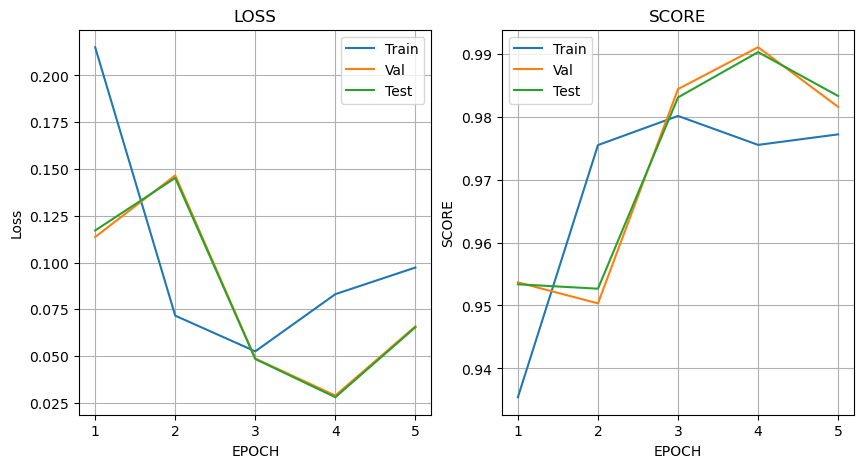

In [21]:
# 학습 후 LOSS 시각화
TH = len(loss_history[0])
fg, axes = plt.subplots(1,2, figsize=(10,5), sharex=True)

axes[0].plot(range(1,TH+1),loss_history[0][:TH], label='Train')
axes[0].plot(range(1,TH+1),loss_history[1][:TH], label='Val')
axes[0].plot(range(1,TH+1),loss_history[2][:TH], label='Test')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,TH+1),f1score_history[0][:TH], label='Train')
axes[1].plot(range(1,TH+1),f1score_history[1][:TH], label='Val')
axes[1].plot(range(1,TH+1),f1score_history[2][:TH], label='Test')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('SCORE')
axes[1].set_title('SCORE')
plt.show()